The goal here is to follow this tutorial 

https://docs.pymc.io/notebooks/GLM-rolling-regression.html

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt

In [5]:
import os

In [100]:
GAMMA = 1/4

I didn't know how to do this in python, so I just exported this data frame from R. 
It is a "rolling window" of cumulative cases

In [10]:
nyc = pd.read_csv('~/Repos/covid-rt/nyc-series.csv')

In [71]:
nycp1 = nyc[2:len(nyc)]
nycm1 = nyc[1:(len(nyc)-1)]

(44,)

In [110]:
del(model_randomwalk)

In [111]:
model_randomwalk = pm.Model()

In [112]:
with model_randomwalk:
    # std of random walk
    sigma_theta = pm.HalfNormal('sigma_theta', sd = 0.1)

    theta = pm.GaussianRandomWalk('alpha', sd=sigma_theta,
                                  shape=len(nycp1.nyc))
    
    likelihood = pm.Poisson('y', mu = np.exp(theta) * nycm1.nyc, observed = nycp1.nyc)

In [113]:
with model_randomwalk:
    trace_rw = pm.sample(tune=1000, cores=2,
                         target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, sigma_theta]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 335.14draws/s]


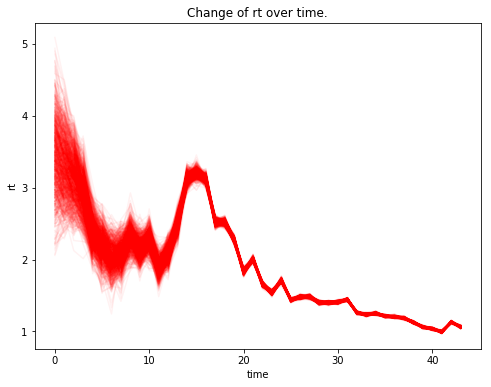

In [114]:
rt = trace_rw['alpha'].T / GAMMA + 1
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111, xlabel='time', ylabel='rt', title='Change of rt over time.')
ax.plot(rt, 'r', alpha=.05);